In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import math
import plotly
import plotly.graph_objs as go
from mpl_toolkits.mplot3d import Axes3D
import plotly.offline as py
py.init_notebook_mode(connected=True)

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold

import torch
from torch import nn, optim, cuda
from torch.utils.data import DataLoader, Dataset

warnings.filterwarnings('ignore')

In [197]:
df = pd.DataFrame()
data_size=1000
df['x']=10*np.random.randn(data_size)
df['y']=10*np.random.randn(data_size)

df['z'] = np.sqrt(df['x']**2+df['y']**2)+2*np.random.randn(data_size)

df['label'] = df['z'].apply(lambda x: 1 if x>10 else 0)

df = pd.concat([
    df, 
    pd.get_dummies(df.label).rename(columns={l:f'label_{l}' for l in df.label.unique()})
], axis=1)

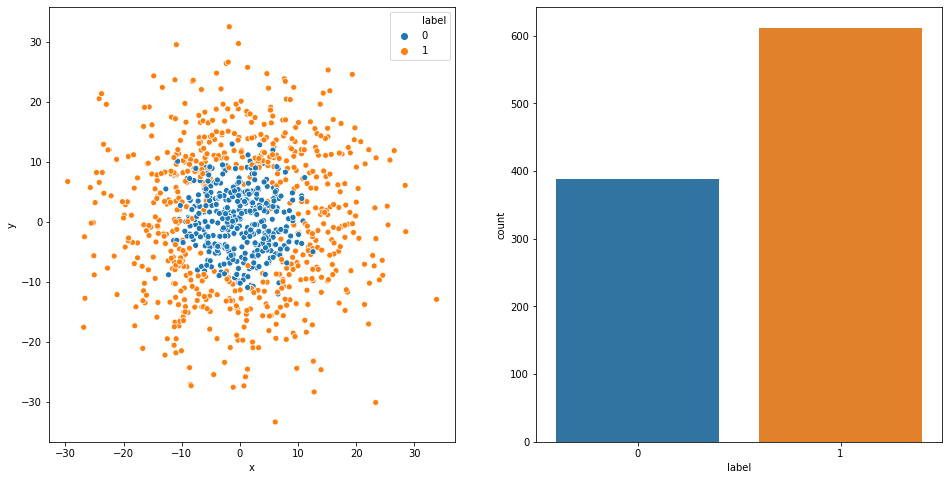

In [198]:
plt.figure(figsize=(16,8))

plt.subplot(1,2,1)
sns.scatterplot(data=df, x='x', y='y', hue='label')

plt.subplot(1,2,2)
sns.countplot(df['label'])

plt.show()

In [199]:
class CreateDataset(Dataset):
    def __init__(self, X, y):
        self.X=X
        self.y=y
        
    def __len__(self):  # len(Dataset)で返す値を指定
        return len(self.X)

    def __getitem__(self, index):  # Dataset[index]で返す値を指定
        # argumentation
        x = self.X[index]
        x = torch.FloatTensor(x)
        
        return {
            'input': x,
            'label': torch.FloatTensor(self.y[index])
        }

In [236]:
class Model_Trainer:
    def __init__(self):
        self.device =  'cuda' if cuda.is_available() else 'cpu'
        self.model = MLPClass().to(self.device)
        self.criterion = nn.BCEWithLogitsLoss()

        self.optimizer = optim.Adam(params=self.model.parameters(), lr=1e-2, weight_decay=1e-6)
        self.scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer=self.optimizer, T_max=10)

    
    def load_params(self, state_dict):
        self.model.load_state_dict(state_dict)

    def train(self, trn_dataloader):
        self.model.train()
        avg_loss=0
        all_preds = []
        all_labels = []
        for data in trn_dataloader:
            self.optimizer.zero_grad()
            x = data['input'].to(self.device)
            label = data['label']   #.squeeze(1)
            label = label.to(self.device)
            x = self.model(x)
            loss = self.criterion(x, label)
            loss.backward()
            self.optimizer.step()
            self.scheduler.step()
            avg_loss += loss.item()/len(trn_dataloader)
            all_preds+=x.detach().cpu().tolist()
            all_labels+=label.cpu().tolist()
            
        return avg_loss, np.array(all_preds), np.array(all_labels)

    def eval(self, val_dataloader):
        self.model.eval()
        avg_loss=0
        preds=[]
        for data in val_dataloader:
            x = data['input'].to(self.device)
            label = data['label'].to(self.device)    #.squeeze(1)
            x = self.model(x)
            loss = self.criterion(x, label)
            preds+=x.detach().cpu().tolist()
            avg_loss += loss.item()/len(val_dataloader)
        return avg_loss, np.array(preds)
    
    def predict(self, data_loader):
        self.model.eval()
        preds = []
        for data in data_loader:
            x = data['input'].to(self.device)
            preds+=self.model(x).detach().cpu().tolist()
        return np.array(preds)

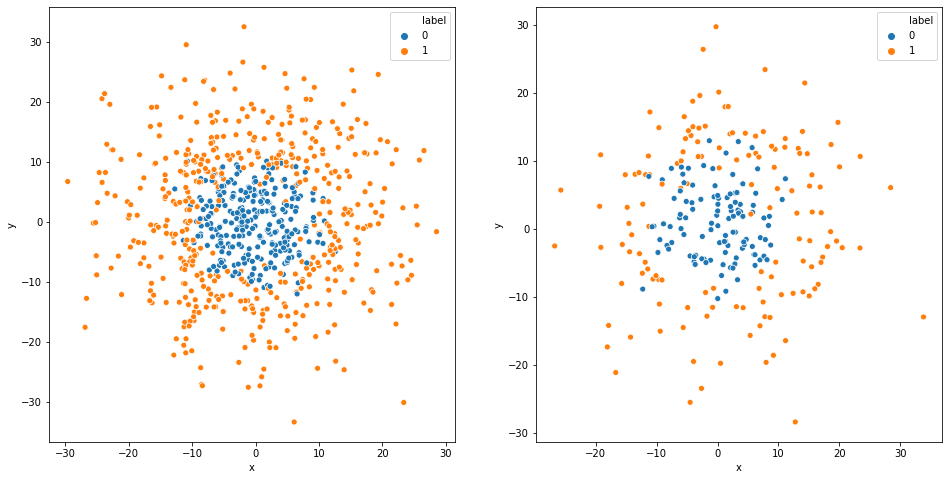

In [237]:
train_df, test_df = train_test_split(df, test_size=0.25, random_state=2020)

plt.figure(figsize=(16,8))

plt.subplot(1,2,1)
sns.scatterplot(data=train_df, x='x', y='y', hue='label')

plt.subplot(1,2,2)
sns.scatterplot(data=test_df, x='x', y='y', hue='label')


plt.show()

In [238]:
train_dataset=CreateDataset(train_df[['x', 'y']].values, train_df[['label_0', 'label_1']].values)
test_dataset=CreateDataset(test_df[['x', 'y']].values, test_df[['label_0', 'label_1']].values)
all_dataset=CreateDataset(df[['x', 'y']].values, df[['label_0', 'label_1']].values)

In [239]:
train_loader = DataLoader(train_dataset, batch_size=200, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=200, shuffle=False)
all_loader = DataLoader(all_dataset, batch_size=200, shuffle=False)

In [240]:
def exp(train_loader, test_loader, epoch_num):
    model_trainer = Model_Trainer()
    trn_loss = []
    val_loss = []
    for e in range(epoch_num):
        trn_avg_loss, all_preds, all_labels = model_trainer.train(train_loader)
        val_avg_loss, x = model_trainer.eval(test_loader) 
        
        trn_loss.append(trn_avg_loss)
        val_loss.append(val_avg_loss)

        print(f'epoch {e+1}  train loss {trn_avg_loss}  val loss {val_avg_loss}')
    return model_trainer, trn_loss, val_loss

In [241]:
class MLPClass(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.lin1=nn.Sequential(nn.Linear(2,2), nn.ReLU(), nn.Linear(2,2))
        self.lin2=nn.Sequential(nn.Linear(2,2), nn.ReLU(), nn.Linear(2,2))
        self.lin3=nn.Sequential(nn.Linear(2,2), nn.ReLU(), nn.Linear(2,2))
        self.lin4=nn.Sequential(nn.Linear(2,2), nn.ReLU(), nn.Linear(2,2))
        self.lin5=nn.Sequential(nn.Linear(2,2), nn.ReLU(), nn.Linear(2,2))
        self.lin6=nn.Sequential(nn.Linear(2,2), nn.ReLU(), nn.Linear(2,2))

        self.softmax = torch.nn.Softmax()

    def forward(self, x):
        x = self.lin1(x)+self.lin2(x)+self.lin3(x)+self.lin4(x)#+self.lin5(x)+self.lin6(x)
        x= self.softmax(x)
        return x

epoch 1  train loss 0.7378119379281998  val loss 0.7330016195774078
epoch 2  train loss 0.7304515391588211  val loss 0.7312067151069641
epoch 3  train loss 0.7287149280309677  val loss 0.7310642898082733
epoch 4  train loss 0.729535385966301  val loss 0.729893684387207
epoch 5  train loss 0.7260395437479019  val loss 0.726780503988266
epoch 6  train loss 0.72108955681324  val loss 0.7223321199417114
epoch 7  train loss 0.7177907824516296  val loss 0.7193904221057892
epoch 8  train loss 0.7139835357666016  val loss 0.7190890908241272
epoch 9  train loss 0.7157311737537384  val loss 0.716344565153122
epoch 10  train loss 0.7123980820178986  val loss 0.7057844400405884
epoch 11  train loss 0.7004162669181824  val loss 0.6902872920036316
epoch 12  train loss 0.6909444332122803  val loss 0.6819427907466888
epoch 13  train loss 0.6861760467290878  val loss 0.6811795830726624
epoch 14  train loss 0.6840543448925018  val loss 0.6743744015693665
epoch 15  train loss 0.6740782856941223  val loss

epoch 122  train loss 0.5502472519874573  val loss 0.5485024750232697
epoch 123  train loss 0.5498003661632538  val loss 0.548516571521759
epoch 124  train loss 0.5496163815259933  val loss 0.5487098693847656
epoch 125  train loss 0.5495035350322723  val loss 0.548347532749176
epoch 126  train loss 0.5498497784137726  val loss 0.5490208268165588
epoch 127  train loss 0.5502305030822754  val loss 0.5490341484546661
epoch 128  train loss 0.5495859235525131  val loss 0.5489977896213531
epoch 129  train loss 0.549445852637291  val loss 0.5485231280326843
epoch 130  train loss 0.5496031492948532  val loss 0.5478494465351105
epoch 131  train loss 0.549861952662468  val loss 0.547843724489212
epoch 132  train loss 0.550134688615799  val loss 0.5478591322898865
epoch 133  train loss 0.5492973625659943  val loss 0.5478619039058685
epoch 134  train loss 0.5493730157613754  val loss 0.5479582250118256
epoch 135  train loss 0.5493409931659698  val loss 0.5481625497341156
epoch 136  train loss 0.54

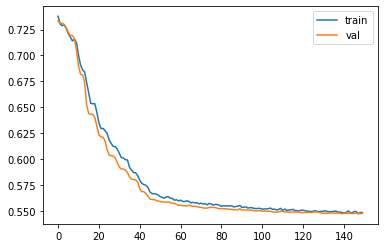

In [242]:
%%time
model_trainer, trn_loss, val_loss = exp(train_loader, test_loader, epoch_num=150)

plt.plot(trn_loss, label='train')
plt.plot(val_loss, label='val')
plt.legend()

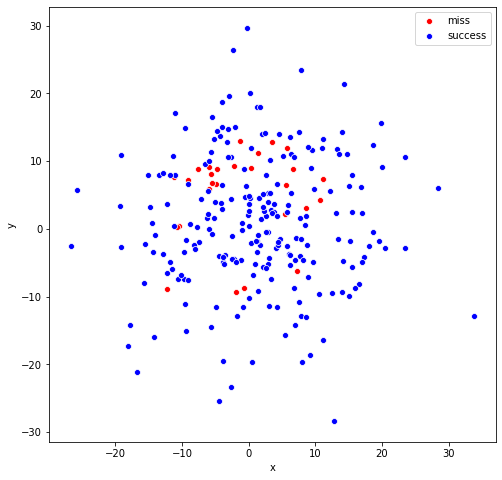

In [243]:
val_avg_loss, x = model_trainer.eval(test_loader) 

test_df['p_x'] = x[:,0]
test_df['p_y'] = x[:,1]
test_df['p'] = test_df['p_y'].apply(lambda x: 1 if x>.5 else 0)

plt.figure(figsize=(8,8))
sns.scatterplot(data=test_df[test_df['p']!=test_df['label']], x='x', y='y', color='red', label='miss')
sns.scatterplot(data=test_df[test_df['p']==test_df['label']], x='x', y='y', color='blue', label='success')
plt.show()

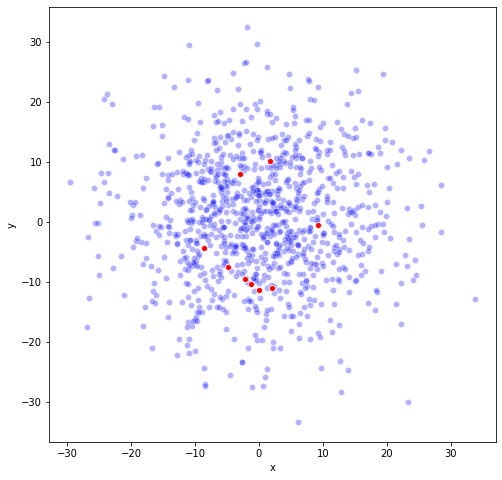

In [244]:
val_avg_loss, x = model_trainer.eval(all_loader) 

df['p_x'] = x[:,0]
df['p_y'] = x[:,1]
df['p'] = df['p_y'].apply(lambda x: 1 if x>.5 else 0)

plt.figure(figsize=(8,8))
sns.scatterplot(data=df, x='x', y='y', color='blue', alpha=0.3)
sns.scatterplot(data=df[(df.p_y>0.45)&(df.p_y<0.55)], x='x', y='y', color='red')
plt.show()

In [245]:
trace1 = go.Scatter3d(       
    x=df['x'].values,
    y=df['y'].values,
    z=df['p_y'].values,
    mode='markers',
    marker=dict(
        opacity=0.3,
        size=2
    )
)

figure_data = [trace1]

layout = go.Layout(
    title = 'The turtle place',
    scene = dict(
        xaxis = dict(title='clear_value'),
        yaxis = dict(title='blur_clear'),
        zaxis = dict(title='after_crop'),
    ),
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)

plt.figure(figsize=(30,30))
fig = go.Figure(data=figure_data)
py.iplot(fig, filename='simple-3d-scatter')

<Figure size 2160x2160 with 0 Axes>

In [246]:
class MLPClass(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.lin1=nn.Sequential(nn.Linear(2,8), nn.ReLU(), nn.Linear(8,2))
        self.lin2=nn.Sequential(nn.Linear(2,4), nn.ReLU(), nn.Linear(4,2))
        self.lin3=nn.Sequential(nn.Linear(2,4), nn.ReLU(), nn.Linear(4,2))
        self.lin4=nn.Sequential(nn.Linear(2,4), nn.ReLU(), nn.Linear(4,2))
        self.lin5=nn.Sequential(nn.Linear(2,4), nn.ReLU(), nn.Linear(4,2))
        self.lin6=nn.Sequential(nn.Linear(2,4), nn.ReLU(), nn.Linear(4,2))

        self.softmax = torch.nn.Softmax()

    def forward(self, x):
        x = self.lin1(x)#+self.lin2(x)+self.lin3(x)+self.lin4(x)+self.lin5(x)+self.lin6(x)
        x= self.softmax(x)
        return x

epoch 1  train loss 0.8024364560842514  val loss 0.7807802557945251
epoch 2  train loss 0.7916973382234573  val loss 0.776373416185379
epoch 3  train loss 0.7862485349178314  val loss 0.7760643362998962
epoch 4  train loss 0.7867628931999207  val loss 0.7738699316978455
epoch 5  train loss 0.7772749066352844  val loss 0.7666630446910858
epoch 6  train loss 0.7651987820863724  val loss 0.7569152116775513
epoch 7  train loss 0.7545458227396011  val loss 0.7519026100635529
epoch 8  train loss 0.7514632642269135  val loss 0.7513215839862823
epoch 9  train loss 0.7504435032606125  val loss 0.7451852560043335
epoch 10  train loss 0.7422447800636292  val loss 0.7272237539291382
epoch 11  train loss 0.7216864973306656  val loss 0.718843400478363
epoch 12  train loss 0.711541011929512  val loss 0.7143769860267639
epoch 13  train loss 0.706233024597168  val loss 0.7140001058578491
epoch 14  train loss 0.7043251544237137  val loss 0.7102015316486359
epoch 15  train loss 0.6893371492624283  val lo

epoch 124  train loss 0.5487444549798965  val loss 0.5483607947826385
epoch 125  train loss 0.5483778864145279  val loss 0.548646479845047
epoch 126  train loss 0.5488173514604568  val loss 0.5485494434833527
epoch 127  train loss 0.5494136661291122  val loss 0.5479170083999634
epoch 128  train loss 0.5475869327783585  val loss 0.5479349493980408
epoch 129  train loss 0.5475663542747498  val loss 0.548033207654953
epoch 130  train loss 0.5493068248033524  val loss 0.5487808585166931
epoch 131  train loss 0.5487249940633774  val loss 0.5473591089248657
epoch 132  train loss 0.5486317425966263  val loss 0.5476502180099487
epoch 133  train loss 0.5484318137168884  val loss 0.5476930439472198
epoch 134  train loss 0.5496053099632263  val loss 0.5478813946247101
epoch 135  train loss 0.5480815768241882  val loss 0.5486757159233093
epoch 136  train loss 0.5479062348604202  val loss 0.547740250825882
epoch 137  train loss 0.5486204475164413  val loss 0.5468322336673737
epoch 138  train loss 0

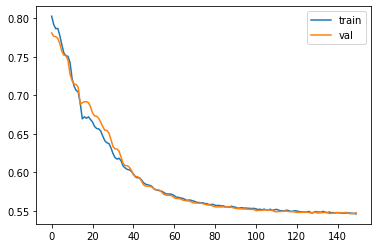

In [247]:
%%time
model_trainer, trn_loss, val_loss = exp(train_loader, test_loader, epoch_num=150)

plt.plot(trn_loss, label='train')
plt.plot(val_loss, label='val')
plt.legend()

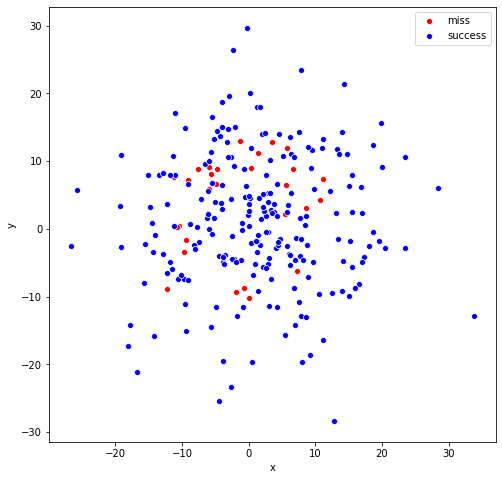

In [248]:
val_avg_loss, x = model_trainer.eval(test_loader) 

test_df['p_x'] = x[:,0]
test_df['p_y'] = x[:,1]
test_df['p'] = test_df['p_y'].apply(lambda x: 1 if x>.5 else 0)

plt.figure(figsize=(8,8))
sns.scatterplot(data=test_df[test_df['p']!=test_df['label']], x='x', y='y', color='red', label='miss')
sns.scatterplot(data=test_df[test_df['p']==test_df['label']], x='x', y='y', color='blue', label='success')
plt.show()

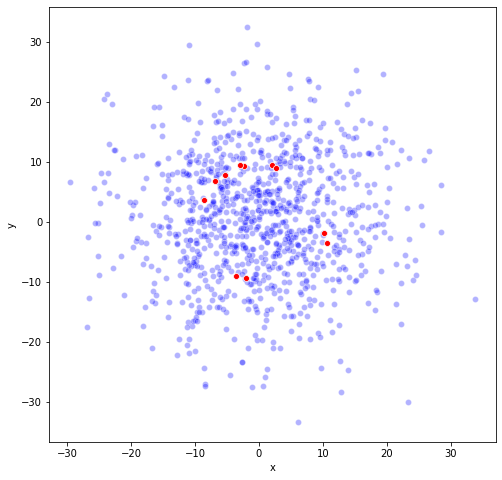

In [249]:
val_avg_loss, x = model_trainer.eval(all_loader) 

df['p_x'] = x[:,0]
df['p_y'] = x[:,1]
df['p'] = df['p_y'].apply(lambda x: 1 if x>.5 else 0)

plt.figure(figsize=(8,8))
sns.scatterplot(data=df, x='x', y='y', color='blue', alpha=0.3)
sns.scatterplot(data=df[(df.p_y>0.45)&(df.p_y<0.55)], x='x', y='y', color='red')
plt.show()

In [250]:
trace1 = go.Scatter3d(       
    x=df['x'].values,
    y=df['y'].values,
    z=df['p_y'].values,
    mode='markers',
    marker=dict(
        opacity=0.3,
        size=2
    )
)

figure_data = [trace1]

layout = go.Layout(
    title = 'The turtle place',
    scene = dict(
        xaxis = dict(title='clear_value'),
        yaxis = dict(title='blur_clear'),
        zaxis = dict(title='after_crop'),
    ),
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)

plt.figure(figsize=(30,30))
fig = go.Figure(data=figure_data)
py.iplot(fig, filename='simple-3d-scatter')

<Figure size 2160x2160 with 0 Axes>

In [251]:
class MLPClass(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.lin1=nn.Sequential(nn.Linear(2,2), nn.ReLU())
        self.lin2=nn.Sequential(nn.Linear(2,2), nn.ReLU())
        self.lin3=nn.Sequential(nn.Linear(2,2), nn.ReLU())
        self.lin4=nn.Sequential(nn.Linear(2,2), nn.ReLU())
        
        self.lin9=nn.Sequential(nn.Linear(8,2))
        self.softmax = torch.nn.Softmax()

    def forward(self, x):
        x = torch.cat((self.lin1(x), self.lin2(x), self.lin3(x), self.lin4(x)), axis=1)
        x = self.lin9(x)
        x= self.softmax(x)
        return x

epoch 1  train loss 0.6614579409360886  val loss 0.6601521670818329
epoch 2  train loss 0.6495312750339508  val loss 0.6578740775585175
epoch 3  train loss 0.6454708576202393  val loss 0.6577142179012299
epoch 4  train loss 0.6448458582162857  val loss 0.6565670967102051
epoch 5  train loss 0.6422263085842133  val loss 0.6549994349479675
epoch 6  train loss 0.6386290490627289  val loss 0.6522956192493439
epoch 7  train loss 0.6345835477113724  val loss 0.6508086621761322
epoch 8  train loss 0.6351829320192337  val loss 0.6506390869617462
epoch 9  train loss 0.6326022893190384  val loss 0.6488698422908783
epoch 10  train loss 0.6322966516017914  val loss 0.6444393396377563
epoch 11  train loss 0.6287481039762497  val loss 0.6397481858730316
epoch 12  train loss 0.6266165375709534  val loss 0.6379362940788269
epoch 13  train loss 0.6246107816696167  val loss 0.6377825140953064
epoch 14  train loss 0.6235961467027664  val loss 0.6368374526500702
epoch 15  train loss 0.6236574649810791  va

epoch 121  train loss 0.5502476543188095  val loss 0.5531919002532959
epoch 122  train loss 0.5487917214632034  val loss 0.5531876683235168
epoch 123  train loss 0.5488705933094025  val loss 0.5531792342662811
epoch 124  train loss 0.5493212342262268  val loss 0.5533769130706787
epoch 125  train loss 0.5489541292190552  val loss 0.5532549321651459
epoch 126  train loss 0.5490071773529053  val loss 0.5535102486610413
epoch 127  train loss 0.5486760437488556  val loss 0.5529461205005646
epoch 128  train loss 0.5502053648233414  val loss 0.5529316365718842
epoch 129  train loss 0.5484761297702789  val loss 0.5526210963726044
epoch 130  train loss 0.5484627336263657  val loss 0.5518655478954315
epoch 131  train loss 0.5487714111804962  val loss 0.5527731478214264
epoch 132  train loss 0.5486332178115845  val loss 0.5520837903022766
epoch 133  train loss 0.5476964712142944  val loss 0.5520460903644562
epoch 134  train loss 0.5474378168582916  val loss 0.5518556833267212
epoch 135  train los

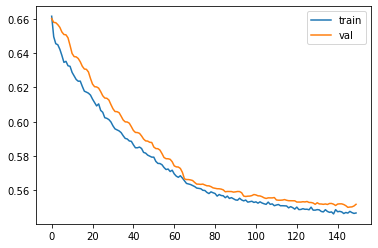

In [252]:
%%time
model_trainer, trn_loss, val_loss = exp(train_loader, test_loader, epoch_num=150)

plt.plot(trn_loss, label='train')
plt.plot(val_loss, label='val')
plt.legend()

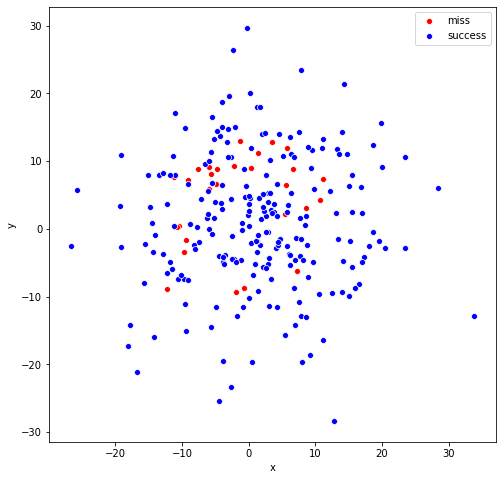

In [253]:
val_avg_loss, x = model_trainer.eval(test_loader) 

test_df['p_x'] = x[:,0]
test_df['p_y'] = x[:,1]
test_df['p'] = test_df['p_y'].apply(lambda x: 1 if x>.5 else 0)

plt.figure(figsize=(8,8))
sns.scatterplot(data=test_df[test_df['p']!=test_df['label']], x='x', y='y', color='red', label='miss')
sns.scatterplot(data=test_df[test_df['p']==test_df['label']], x='x', y='y', color='blue', label='success')
plt.show()

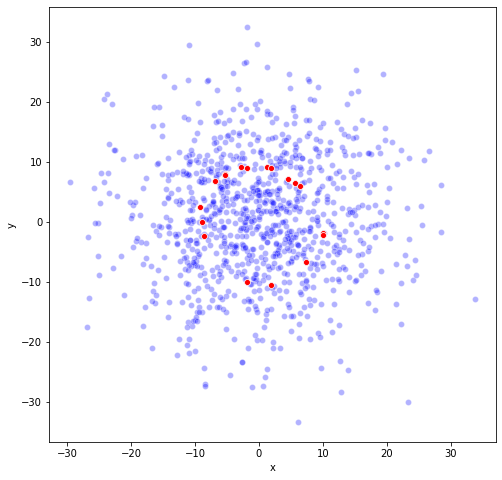

In [254]:
val_avg_loss, x = model_trainer.eval(all_loader) 

df['p_x'] = x[:,0]
df['p_y'] = x[:,1]
df['p'] = df['p_y'].apply(lambda x: 1 if x>.5 else 0)

plt.figure(figsize=(8,8))
sns.scatterplot(data=df, x='x', y='y', color='blue', alpha=0.3)
sns.scatterplot(data=df[(df.p_y>0.45)&(df.p_y<0.55)], x='x', y='y', color='red')
plt.show()

In [255]:
trace1 = go.Scatter3d(       
    x=df['x'].values,
    y=df['y'].values,
    z=df['p_y'].values,
    mode='markers',
    marker=dict(
        opacity=0.3,
        size=2
    )
)

figure_data = [trace1]

layout = go.Layout(
    title = 'The turtle place',
    scene = dict(
        xaxis = dict(title='clear_value'),
        yaxis = dict(title='blur_clear'),
        zaxis = dict(title='after_crop'),
    ),
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)

plt.figure(figsize=(30,30))
fig = go.Figure(data=figure_data)
py.iplot(fig, filename='simple-3d-scatter')

<Figure size 2160x2160 with 0 Axes>

In [256]:
class MLPClass(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.lin1=nn.Sequential(nn.Linear(2,2), nn.ReLU(), nn.Linear(2,2), nn.Softmax())
        self.lin2=nn.Sequential(nn.Linear(2,2), nn.ReLU(), nn.Linear(2,2), nn.Softmax())
        self.lin3=nn.Sequential(nn.Linear(2,2), nn.ReLU(), nn.Linear(2,2), nn.Softmax())
        self.lin4=nn.Sequential(nn.Linear(2,2), nn.ReLU(), nn.Linear(2,2), nn.Softmax())
        self.lin5=nn.Sequential(nn.Linear(2,2), nn.ReLU(), nn.Linear(2,2), nn.Softmax())
        self.lin6=nn.Sequential(nn.Linear(2,2), nn.ReLU(), nn.Linear(2,2), nn.Softmax())

        self.softmax = torch.nn.Softmax()

    def forward(self, x):
        x_1 = self.lin1(x)
        x_2 = self.lin2(x)
        x_3 = self.lin3(x)
        x_4 = self.lin4(x)
        x_5 = self.lin5(x)
        x_6 = self.lin6(x)
        x = x_1+x_2+x_3+x_4+x_5+x_6
        x= self.softmax(x)
        return x, (x_1, x_2, x_3, x_4, x_5, x_6)

In [257]:
class Model_Trainer:
    def __init__(self):
        self.device =  'cuda' if cuda.is_available() else 'cpu'
        self.model = MLPClass().to(self.device)
        self.criterion = nn.BCEWithLogitsLoss()

        self.optimizer = optim.Adam(params=self.model.parameters(), lr=1e-2, weight_decay=1e-6)
        self.scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer=self.optimizer, T_max=10)

    
    def load_params(self, state_dict):
        self.model.load_state_dict(state_dict)

    def train(self, trn_dataloader):
        self.model.train()
        avg_loss=0
        all_preds = []
        all_labels = []
        for data in trn_dataloader:
            self.optimizer.zero_grad()
            x = data['input'].to(self.device)
            label = data['label']   #.squeeze(1)
            label = label.to(self.device)
            x, x_ = self.model(x)
            loss = self.criterion(x, label)
            loss.backward()
            self.optimizer.step()
            self.scheduler.step()
            avg_loss += loss.item()/len(trn_dataloader)
            all_preds+=x.detach().cpu().tolist()
            all_labels+=label.cpu().tolist()
            
        return avg_loss, np.array(all_preds), np.array(all_labels)

    def eval(self, val_dataloader):
        self.model.eval()
        avg_loss=0
        preds=[]
        for data in val_dataloader:
            x = data['input'].to(self.device)
            label = data['label'].to(self.device)    #.squeeze(1)
            x, x_ = self.model(x)
            loss = self.criterion(x, label)
            preds+=x.detach().cpu().tolist()
            avg_loss += loss.item()/len(val_dataloader)
        return avg_loss, np.array(preds)
    
    def predict(self, data_loader):
        self.model.eval()
        preds = []
        for data in data_loader:
            x, x_ = data['input'].to(self.device)
            preds+=self.model(x).detach().cpu().tolist()
        return np.array(preds)

epoch 1  train loss 0.7114153355360031  val loss 0.703819990158081
epoch 2  train loss 0.6949294209480286  val loss 0.6966021656990051
epoch 3  train loss 0.6899617165327072  val loss 0.6959646046161652
epoch 4  train loss 0.6888493001461029  val loss 0.690674215555191
epoch 5  train loss 0.675523579120636  val loss 0.6769836246967316
epoch 6  train loss 0.6634062975645065  val loss 0.6672890484333038
epoch 7  train loss 0.6573263704776764  val loss 0.6636284589767456
epoch 8  train loss 0.6547772139310837  val loss 0.6632795333862305
epoch 9  train loss 0.6527974456548691  val loss 0.6602533459663391
epoch 10  train loss 0.6489605605602264  val loss 0.6513649821281433
epoch 11  train loss 0.6424833834171295  val loss 0.6423430740833282
epoch 12  train loss 0.6377342790365219  val loss 0.6387024521827698
epoch 13  train loss 0.635815903544426  val loss 0.6384119689464569
epoch 14  train loss 0.6352729201316833  val loss 0.6361803412437439
epoch 15  train loss 0.6327297985553741  val lo

epoch 121  train loss 0.5767602622509003  val loss 0.578610360622406
epoch 122  train loss 0.5767081677913666  val loss 0.5786132514476776
epoch 123  train loss 0.5768232047557831  val loss 0.5786081552505493
epoch 124  train loss 0.576652318239212  val loss 0.5786876082420349
epoch 125  train loss 0.5759457051753998  val loss 0.5788846611976624
epoch 126  train loss 0.5769058614969254  val loss 0.5792171955108643
epoch 127  train loss 0.5769259631633759  val loss 0.5789874494075775
epoch 128  train loss 0.5759435594081879  val loss 0.5789728760719299
epoch 129  train loss 0.576364055275917  val loss 0.5788663625717163
epoch 130  train loss 0.5761837363243103  val loss 0.5786116421222687
epoch 131  train loss 0.5763197690248489  val loss 0.5784838199615479
epoch 132  train loss 0.5762264132499695  val loss 0.5784652829170227
epoch 133  train loss 0.5752284228801727  val loss 0.5784660577774048
epoch 134  train loss 0.5765344202518463  val loss 0.5784083306789398
epoch 135  train loss 0

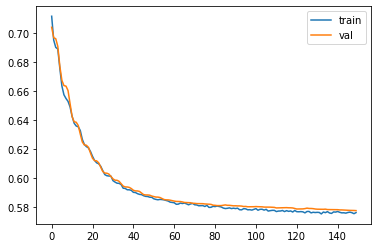

In [258]:
%%time
model_trainer, trn_loss, val_loss = exp(train_loader, test_loader, epoch_num=150)

plt.plot(trn_loss, label='train')
plt.plot(val_loss, label='val')
plt.legend()

In [259]:
x_2 = []
for data in all_loader:
    x = data['input'].to('cuda')
    x, x_ = model_trainer.model(x)
    x = torch.cat(x_, axis=1)
    x_2 += x.detach().cpu().tolist()

In [260]:
x_2 = np.array(x_2)
for i in range(6):
    df[f'p_{i+1}'] = x_2[:,2*i+1]

In [261]:
df

,x,y,z,label,label_0,label_1,p_x,p_y,p,p_1,p_2,p_3,p_4,p_5,p_6
0,24.007208,-9.684524,26.028017,1,0,1,2.361028e-10,1.000000,1,1.127735e-17,0.999994,0.999904,0.557306,0.999977,0.997573
1,13.958837,-24.655172,29.735353,1,0,1,1.419449e-12,1.000000,1,1.922367e-10,0.996159,1.000000,0.999868,0.999992,0.586173
2,-2.399489,3.660256,4.970020,0,1,0,9.997551e-01,0.000245,0,1.437512e-01,0.076560,0.406558,0.206495,0.094327,0.091510
3,-8.134791,11.097164,12.974916,1,0,1,7.774768e-04,0.999223,1,6.553775e-01,0.895281,0.994114,0.688077,0.989990,0.091510
4,-17.596145,-3.535202,15.209954,1,0,1,1.449274e-08,1.000000,1,9.985805e-01,0.999723,0.455525,0.830697,0.051428,0.995456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,8.664354,20.336741,25.350782,1,0,1,5.168821e-08,1.000000,1,3.370120e-08,0.868043,0.996301,0.999939,0.999981,0.999795
996,-20.199711,3.333985,23.051315,1,0,1,3.965435e-10,1.000000,1,9.994100e-01,0.999979,0.985091,0.130088,0.298114,0.976165
997,-8.968415,0.008623,11.761551,1,0,1,5.109044e-01,0.489096,0,8.625605e-01,0.865485,0.358598,0.161589,0.051428,0.551569
998,5.872504,3.456007,6.895283,0,1,0,9.645822e-01,0.035418,0,8.198715e-06,0.542949,0.107835,0.671661,0.067063,0.799152


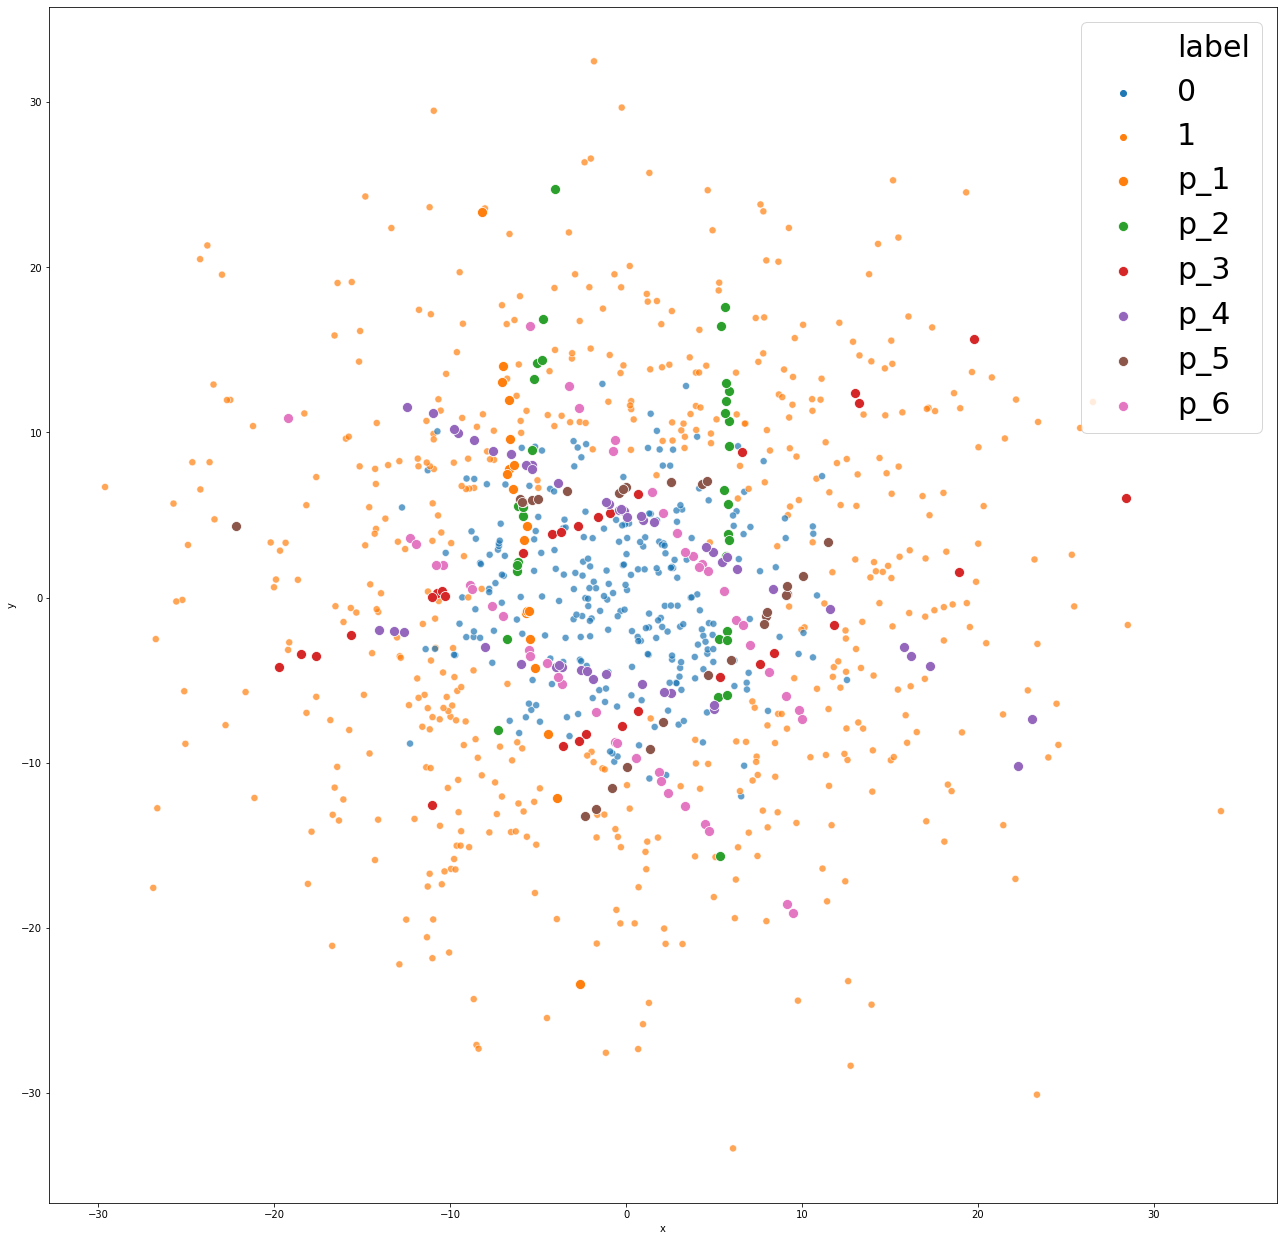

In [262]:
plt.figure(figsize=(22,22))
sns.scatterplot(data=df, x='x', y='y', alpha=0.7, hue='label', s=50)
for i in range(6):
    sns.scatterplot(data=df[(df[f'p_{i+1}']>0.45)&(df[f'p_{i+1}']<0.55)], x='x', y='y', label=f'p_{i+1}', s=100)

plt.legend(fontsize=30)
plt.show()